In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle
import json
import torch

In [53]:
import openslide
import pandas as pd
from PIL import Image

def extract_patch(df_row, patch_size, img_dir):
    """
    Extracts a patch centered around the annotation from a given row of the dataframe.

    Args:
    df_row (pd.Series): A row from the dataframe.
    patch_size (int): The size of the square patch to extract.

    Returns:
    Image: An extracted patch as a PIL Image.
    """
    # Extract the necessary information from the dataframe row
    x_center = df_row['x']
    y_center = df_row['y']
    filename = df_row['filename']
    
    # Open the slide using OpenSlide
    slide_path = f'{img_dir}/{filename}'  # Update with the actual path to the slides
    slide = openslide.OpenSlide(slide_path)

    # Calculate the top-left corner of the patch
    half_size = patch_size // 2
    x_start = int(x_center - half_size)
    y_start = int(y_center - half_size)

    # Extract the patch (level 0 by default)
    patch = slide.read_region((x_start, y_start), 0, (patch_size, patch_size))

    # Convert the patch to RGB (removes alpha channel if present)
    patch = patch.convert('RGB')
    

    return patch


In [54]:
json_file = 'annotations/MIDOG2022_6class.json'
anno_file = 'annotations/MIDOG2022_training.csv'
img_dir = '/data/patho/MIDOG2/'

In [29]:
annos = pd.read_csv(anno_file)
json_dict = json.load(open(json_file, 'rb'))
print(json_dict.keys())

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])


In [30]:
json_dict['categories']

[{'id': 1, 'name': 'Prophase', 'supercategory': 'Cell'},
 {'id': 2, 'name': 'Prometaphase', 'supercategory': 'Cell'},
 {'id': 3, 'name': 'Metaphase', 'supercategory': 'Cell'},
 {'id': 4, 'name': 'Anaphase', 'supercategory': 'Cell'},
 {'id': 5, 'name': 'Telophase', 'supercategory': 'Cell'},
 {'id': 6, 'name': 'Atypical', 'supercategory': 'Cell'}]

In [31]:
[a['bbox'] for a in json_dict['annotations'][:10]]

[[3, 45, 36, 43],
 [6074, 3333, 54, 57],
 [6475, 3736, 66, 55],
 [3466, 3799, 56, 56],
 [1585, 4412, 59, 75],
 [509, 4886, 55, 46],
 [5797, 575, 46, 50],
 [2741, 2078, 53, 63],
 [4170, 2467, 43, 51],
 [2631, 2490, 57, 51]]

In [32]:
image_id_to_filename = {image['id']: image['file_name'] for image in json_dict['images']}
cat_id_to_label = {cat['id']: cat['name'] for cat in json_dict['categories']}

In [33]:
df = pd.DataFrame.from_dict(json_dict['annotations'])

df['x'] = df['bbox'].apply(lambda x: x[0] + x[2] / 2)
df['y'] = df['bbox'].apply(lambda x: x[1] + x[3] / 2)
df['filename'] = df['image_id'].map(image_id_to_filename)
df['split'] = df['filename'].apply(lambda x: annos.query('filename == @x')['split'].unique().item())
df['tumortype'] = df['filename'].apply(lambda x: annos.query('filename == @x')['tumortype'].unique().item())

df = df.drop(['segmentation', 'area', 'iscrowd', 'bbox'], axis=1)
df.head()

,id,image_id,category_id,x,y,filename,split,tumortype
0,0,0,1,21.0,66.5,151.tiff,train,canine lung cancer
1,1,0,1,6101.0,3361.5,151.tiff,train,canine lung cancer
2,2,0,1,6508.0,3763.5,151.tiff,train,canine lung cancer
3,3,0,1,3494.0,3827.0,151.tiff,train,canine lung cancer
4,4,0,1,1614.5,4449.5,151.tiff,train,canine lung cancer


/data/patho/MIDOG2//151.tiff


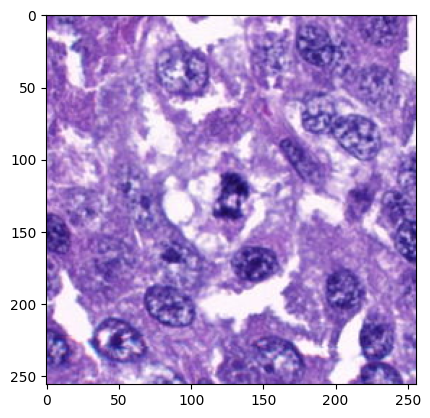

In [34]:
# Example: Extract a 256x256 patch for the first row
patch = extract_patch(df.loc[7], patch_size=256, img_dir=img_dir)

plt.imshow(patch)

In [11]:
midog_21_json_file = 'annotations/MIDOG2021_atypia_merge.json'
midog_21_json_dict = json.load(open(midog_21_json_file, 'rb'))
midog_21_json_dict.keys()

dict_keys(['info', 'images', 'categories', 'annotations'])

In [12]:
midog_21_json_dict['categories']

[{'id': 1, 'name': 'mitotic figure'},
 {'id': 2, 'name': 'not mitotic figure'},
 {'id': 3, 'name': 'Mitosis - AMF OTHER'},
 {'id': 4,
  'name': 'Mitosis - AMF BIPOLAR ASYMMETRIC CAN ALSO HAVE SEGREGATION'},
 {'id': 5, 'name': 'Mitosis - AMF SEGREGATION ONLY'},
 {'id': 6,
  'name': 'Mitosis - AMF MULTIPOLAR ASYMMETRY CAN ALSO HAVE SEGREGATION'},
 {'id': 7, 'name': 'Mitosis - RING SHAPE (PROMETAPHASE OR METAPHASE)'},
 {'id': 8, 'name': 'Mitosis - NORMAL ANAPHASE-TELOPHASE'},
 {'id': 9, 'name': 'Mitosis - NORMAL PROMETAPHASE'},
 {'id': 10, 'name': 'Mitosis - NORMAL METAPHASE'},
 {'id': 11, 'name': 'BIOMAG_pro'},
 {'id': 12, 'name': 'BIOMAG_prometa'},
 {'id': 13, 'name': 'BIOMAG_meta'},
 {'id': 14, 'name': 'BIOMAG_ana'},
 {'id': 15, 'name': 'BIOMAG_telo'},
 {'id': 16, 'name': 'BIOMAG_atyp'}]

In [13]:
[a['bbox'] for a in midog_21_json_dict['annotations'][:10]]

[[4336, 346, 50, 50],
 [756, 872, 50, 50],
 [270, 4044, 50, 50],
 [6672.5, 706.5, 50.0, 50.0],
 [1872, 319, 50, 50],
 [4397, 191, 50, 50],
 [1842, 1558, 50, 50],
 [3783, 2346, 50, 50],
 [5319, 3252, 50, 50],
 [6242, 3193, 50, 50]]

In [15]:
midog21_df = pd.DataFrame.from_dict(midog_21_json_dict['annotations'])

midog21_id_to_filename = {image['id']: image['file_name'][:-4] + '.tiff' for image in midog_21_json_dict['images']}
midog_21_cat_to_midog22 = {k: v for k, v in zip(range(11,17), range(1,7))}

midog21_df = midog21_df.query('category_id >= 11')
midog21_df['x'] = midog21_df['bbox'].apply(lambda x: x[0] + x[2] / 2)
midog21_df['y'] = midog21_df['bbox'].apply(lambda x: x[1] + x[3] / 2)
midog21_df['filename'] = midog21_df['image_id'].map(midog21_id_to_filename)
midog21_df['split'] = midog21_df['filename'].apply(lambda x: annos.query('filename == @x')['split'].unique().item())
midog21_df['tumortype'] = midog21_df['filename'].apply(lambda x: annos.query('filename == @x')['tumortype'].unique().item())

midog21_df['category_id'] = midog21_df['category_id'].map(midog_21_cat_to_midog22)


midog21_df = midog21_df.drop(['iscrowd', 'bbox', 'area'], axis=1)
midog21_df.head()

,category_id,image_id,id,x,y,filename,split,tumortype
3761,2,2,3762,4421.0,218.0,002.tiff,train,human breast cancer
3762,3,2,3763,1313.0,2784.5,002.tiff,train,human breast cancer
3763,2,2,3764,3534.5,2489.0,002.tiff,train,human breast cancer
3764,2,2,3765,2190.5,3262.5,002.tiff,train,human breast cancer
3765,2,2,3766,5342.0,3267.5,002.tiff,train,human breast cancer


In [16]:
comb_df = pd.concat([midog21_df, df])
comb_df['label'] = comb_df['category_id']

comb_df = comb_df.drop(['category_id', 'image_id', 'id'], axis=1)
comb_df

,x,y,filename,split,tumortype,label
3761,4421.0,218.0,002.tiff,train,human breast cancer,2
3762,1313.0,2784.5,002.tiff,train,human breast cancer,3
3763,3534.5,2489.0,002.tiff,train,human breast cancer,2
3764,2190.5,3262.5,002.tiff,train,human breast cancer,2
3765,5342.0,3267.5,002.tiff,train,human breast cancer,2
...,...,...,...,...,...,...
7204,1903.5,1629.0,353.tiff,train,human neuroendocrine tumor,6
7205,1289.0,1789.0,353.tiff,train,human neuroendocrine tumor,6
7206,1589.0,3329.5,353.tiff,train,human neuroendocrine tumor,6
7207,6891.5,3747.0,353.tiff,train,human neuroendocrine tumor,6


In [17]:
comb_df.label.unique()

array([2, 3, 1, 4, 5, 6])

In [18]:
imposter_df = annos.query('label == 2')
imposter_df['label'] = imposter_df['label'] - 2 # make imposter label 0
imposter_df

/tmp/ipykernel_2948558/953883631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imposter_df['label'] = imposter_df['label'] - 2 # make imposter label 0


,x,y,label,filename,slide,split,tumortype
0,4361.0,371.0,0,001.tiff,1,train,human breast cancer
1,781.0,897.0,0,001.tiff,1,train,human breast cancer
2,295.0,4069.0,0,001.tiff,1,train,human breast cancer
3,6697.5,731.5,0,001.tiff,1,train,human breast cancer
4,1897.0,344.0,0,002.tiff,2,train,human breast cancer
...,...,...,...,...,...,...,...
20547,4626.5,2460.0,0,354.tiff,354,train,human neuroendocrine tumor
20548,1864.5,937.5,0,354.tiff,354,train,human neuroendocrine tumor
20549,2784.0,3272.0,0,354.tiff,354,train,human neuroendocrine tumor
20550,4738.0,1398.5,0,354.tiff,354,train,human neuroendocrine tumor


In [19]:
all_df = pd.concat([comb_df, imposter_df], ignore_index=True)
all_df.to_csv('annotations/MIDOG2022_training_subtyping.csv', index=False)

In [20]:
all_df.loc[1]['filename']

'002.tiff'

/data/patho/MIDOG2/002.tiff


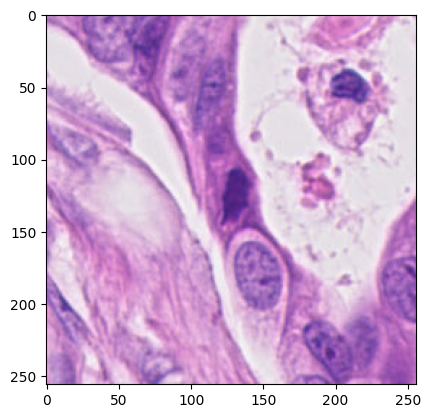

In [21]:
# Example: Extract a 256x256 patch for the first row
patch = extract_patch(all_df.loc[0], patch_size=256)

plt.imshow(patch)

### Make lung subtyping dataset

In [55]:
json_file = '/data/patho/biomag/lung/lung_test_6class.json'
img_dir = '/data/patho/biomag/lung/images'

In [56]:
json_dict = json.load(open(json_file, 'rb'))
print(json_dict.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [57]:
json_dict['categories']

[{'id': 1, 'name': 'Prophase', 'supercategory': 'Cell'},
 {'id': 2, 'name': 'Prometaphase', 'supercategory': 'Cell'},
 {'id': 3, 'name': 'Metaphase', 'supercategory': 'Cell'},
 {'id': 4, 'name': 'Anaphase', 'supercategory': 'Cell'},
 {'id': 5, 'name': 'Telophase', 'supercategory': 'Cell'},
 {'id': 6, 'name': 'Negative', 'supercategory': 'Cell'}]

In [58]:
json_dict['annotations'][0]

{'id': 19570,
 'image_id': 9723,
 'category_id': 6,
 'bbox': [429.0, 175.0, 49.0, 91.0],
 'segmentation': [[444,
   175,
   445,
   175,
   446,
   175,
   447,
   175,
   448,
   176,
   449,
   176,
   450,
   176,
   451,
   176,
   452,
   176,
   453,
   176,
   454,
   176,
   455,
   176,
   456,
   177,
   457,
   177,
   458,
   177,
   459,
   177,
   460,
   177,
   461,
   177,
   462,
   177,
   463,
   177,
   464,
   178,
   465,
   178,
   466,
   178,
   467,
   178,
   468,
   178,
   469,
   178,
   470,
   178,
   471,
   178,
   472,
   179,
   473,
   179,
   473,
   180,
   474,
   181,
   474,
   182,
   475,
   183,
   475,
   184,
   476,
   185,
   477,
   186,
   478,
   187,
   478,
   188,
   478,
   189,
   478,
   190,
   478,
   191,
   478,
   192,
   478,
   193,
   478,
   194,
   478,
   195,
   478,
   196,
   478,
   197,
   478,
   198,
   478,
   199,
   478,
   200,
   478,
   201,
   478,
   202,
   478,
   203,
   478,
   204,
   478,
   205,

In [59]:
image_id_to_filename = {image['id']: image['file_name'] for image in json_dict['images']}
cat_id_to_label = {cat['id']: cat['name'] for cat in json_dict['categories']}

In [67]:
df = pd.DataFrame.from_dict(json_dict['annotations'])

df['x'] = df['bbox'].apply(lambda x: x[0] + x[2] / 2)
df['y'] = df['bbox'].apply(lambda x: x[1] + x[3] / 2)
df['filename'] = df['image_id'].map(image_id_to_filename)

df = df.drop(['segmentation', 'area', 'iscrowd', 'bbox', 'image_id', 'id', 'supercategory'], axis=1)
df = df.rename({'category_id': 'label'}, axis=1)
df.head()

,label,x,y,filename
0,6,453.5,220.5,6028-22_1_Whole_Slide_p396.png
1,6,425.5,326.0,6028-22_1_Whole_Slide_p403.png
2,6,728.0,807.5,6028-22_1_Whole_Slide_p403.png
3,6,861.0,318.0,6028-22_1_Whole_Slide_p974.png
4,6,667.5,583.5,6028-22_1_Whole_Slide_p974.png


In [69]:
df.to_csv('annotations/lung_test_6class.csv', index=False)

In [4]:
import pandas as pd

# make lung data binary
df = pd.read_csv('annotations/lung_test_6class.csv')
df = df.query('label != 6') # remove negatives
df.loc[:, 'label'] = 0  # make all MFs the 0 class 
df.to_csv('annotations/lung_test_1class.csv', index=False)